In [1]:
prm_seal_population = io.load('prm_seal_population')
prm_seal_population

2019-06-28 04:42:20,916 - kedro.io.data_catalog - INFO - Loading data from `prm_seal_population` (CSVLocalDataSet)...


,Years,Fermented Seal Population (Thousands)
0,-10.040080,22.233980
1,0.000000,3.507502
2,0.030060,3.523078
3,0.060120,3.922211
4,0.090180,3.630186
5,0.120240,3.917598
6,0.150301,3.930257
7,0.180361,3.675354
8,0.210421,3.732614
9,0.240481,3.915168


1. Fit the model using robust regression.  Compute the robust standard deviation of the residuals (RSDR, defined in Equation 1).

In [2]:
import numpy as np


def func(t, C, k, m):
    r"""Define logistic growth :math:`g(t)=\frac{C}{1+exp(-k(t-m))}`."""
    # pylint: disable=invalid-name
    return C / (1 + np.exp(-k * (t - m)))

In [3]:
xdata = prm_seal_population.Years * 10**3
ydata = prm_seal_population['Fermented Seal Population (Thousands)'] * 10**3

In [4]:
from scipy.optimize import curve_fit


popt, pcov = curve_fit(func, xdata, ydata)
popt

/anaconda3/envs/rout-example/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


array([2.42600405e+04, 4.18607328e-04, 4.42759188e+03])

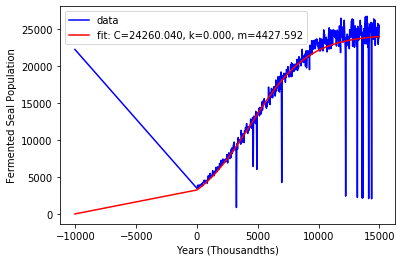

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: C=%5.3f, k=%5.3f, m=%5.3f' % tuple(popt))
plt.xlabel('Years (Thousandths)')
plt.ylabel('Fermented Seal Population')
plt.legend()
plt.show()

In [6]:
residuals = abs(ydata - func(xdata, *popt)) / func(xdata, *popt)  # Weighted
P68 = np.percentile(residuals, 68.27)

N = xdata.size
K = 3
RSDR = P68 * N / (N-K)

2. Decide on a value for Q.  We recommend setting Q to 1%.

In [7]:
Q = 0.01

3. Rank the absolute value of the residuals from low to high, so ResidualN corresponds to the point furthest from the curve.

In [8]:
import pandas as pd


residuals_ranked = pd.Series(residuals, index=prm_seal_population.index).sort_values()
residuals_ranked

56       0.000146
106      0.000178
284      0.000277
251      0.000546
100      0.000906
166      0.001069
186      0.001092
147      0.001126
248      0.001266
342      0.001510
287      0.001601
51       0.001688
244      0.001841
61       0.001878
146      0.001880
135      0.002121
269      0.002325
304      0.002481
312      0.002575
316      0.002693
492      0.003012
307      0.003029
400      0.003509
159      0.003549
241      0.003624
371      0.003650
80       0.003802
405      0.004280
306      0.004674
115      0.004758
          ...    
10       0.111440
103      0.112362
35       0.113343
428      0.113894
122      0.116816
461      0.118958
425      0.119099
465      0.121219
403      0.121948
53       0.125535
6        0.132819
21       0.133785
67       0.135944
394      0.139341
32       0.140350
5        0.141425
44       0.146460
37       0.152279
3        0.167773
155      0.489657
165      0.547734
233      0.762160
407      0.894865
109      0.900182
439      0

4. Loop from i = int(0.70*N) to N (we only test the 30% of the points furthest from the curve).

In [9]:
from scipy import stats


outlier = []
for i, (index, residual) in enumerate(residuals_ranked.iteritems()):
    if i < 0.70 * N:
        outlier.append(False)
        continue
    alpha = Q * (N - i) / N  # i is 0-indexed here, 1-indexed in the paper
    t = residual / RSDR
    
    # c. Compute the two-tailed P value from the t distribution with N-K degrees of freedom (N is number of data points; K is number of parameters fit by nonlinear regression).
    p = 2 * stats.t.sf(t, N - K)
    outlier.append(p < alpha)

pd.Series(outlier, residuals_ranked.index).sum()

11

In [10]:
joined = prm_seal_population.join(pd.Series(outlier, index=residuals_ranked.index, name='Outlier'))
joined[joined.Outlier]

,Years,Fermented Seal Population (Thousands),Outlier
0,-10.040080,22.233980,True
109,3.246493,0.917431,True
155,4.629259,6.451613,True
165,4.929860,6.060606,True
233,6.973948,4.291845,True
407,12.234469,2.457002,True
439,13.196393,2.277904,True
452,13.587174,2.212389,True
454,13.647295,2.202643,True
470,14.128257,2.127660,True


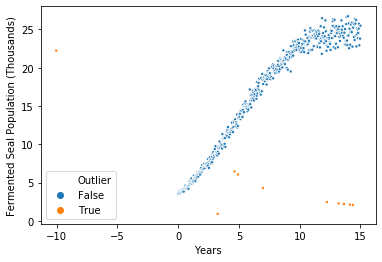

In [11]:
import seaborn as sns


sns.scatterplot('Years', 'Fermented Seal Population (Thousands)', hue='Outlier', data=joined, s=10)